In [1]:
%load_ext autoreload
%autoreload 2



In [2]:
#%%
from ntm import NTM
from dataloader import repeat_copy_dataloader
from torch import nn, optim
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm 
#%%

In [3]:
seq_width=8
min_seq_len = 1
max_seq_len = 10
min_repeat = 1
max_repeat = 10

input_size=seq_width+2
output_size= seq_width+1
controller_size=100
memory_units=128
memory_unit_size=20
batch_size=1
num_heads=1
total_iteration =100000
num_batches = total_iteration//batch_size 



In [4]:
device = torch.device("cpu")
data = repeat_copy_dataloader(num_batches=num_batches,
                              batch_size=batch_size,
                              seq_width=seq_width,
                              min_seq_len=min_seq_len,
                              max_seq_len=max_seq_len,
                              min_repeat= min_repeat,
                              max_repeat= max_repeat,
                              device = device
                             )

ntm = NTM(input_size,output_size,controller_size,memory_units,memory_unit_size,num_heads,device)

criterion = nn.BCELoss()
optimizer = optim.RMSprop(ntm.parameters(),
                          lr=1e-4,
                          alpha=0.95,
                          momentum=0.9)

In [ ]:
#%%
print("Starting training")
print_every = 500
losses =[]
errors =[]
best_error = 1e6
for batch, (x,y) in(enumerate(data)):
    optimizer.zero_grad()
    ntm.reset(batch_size)
    
#     print("Sendning inputs")
    for i in range(x.size(0)):
        input = x[i]
        ntm(input)

    outputs = torch.zeros(y.size()).to(device)

    zero_input = torch.zeros([batch_size,input_size]).to(device)
#     print("Finding Outputs")
    for i in range(y.size(0)):
        outputs[i],_ = ntm(zero_input)
    
#     print("Backprop step")
#     print(f"Outputs {outputs}")
#     print(f"y {y}")
    loss = criterion(outputs, y)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_value_(ntm.parameters(), 10)
    optimizer.step()
    
    out_binarized = outputs.clone().data
    out_binarized = out_binarized.cpu().detach().apply_(lambda x: 0 if x < 0.5 else 1).to(device)
    
    # The cost is the number of error bits per sequence
    cost = torch.sum(torch.abs(out_binarized - y.data))
    errors.append(cost.item()/batch_size)
    best_error = min(best_error,losses[-1])
    if (batch%print_every ==0 or best_error == losses[-1]):
        print(f"Finished batch: {batch}, loss:{losses[-1]:.3e}, cost: {errors[-1]}")
        torch.save(ntm.state_dict(), f'checkpoints/repeat_copy/v2-{batch}_error_{losses[-1]:.3e}_cost_{int(errors[-1])}.pt')


Starting training
Finished batch: 0, loss:6.036e-01, cost: 20.0
Finished batch: 205, loss:5.939e-01, cost: 26.0
Finished batch: 341, loss:5.917e-01, cost: 145.0
Finished batch: 395, loss:5.789e-01, cost: 30.0
Finished batch: 425, loss:5.469e-01, cost: 10.0
Finished batch: 500, loss:6.306e-01, cost: 290.0
Finished batch: 527, loss:5.241e-01, cost: 3.0
Finished batch: 609, loss:5.194e-01, cost: 24.0
Finished batch: 617, loss:4.626e-01, cost: 30.0
Finished batch: 672, loss:4.361e-01, cost: 10.0
Finished batch: 767, loss:4.291e-01, cost: 24.0
Finished batch: 789, loss:4.105e-01, cost: 21.0
Finished batch: 794, loss:3.635e-01, cost: 5.0
Finished batch: 832, loss:3.343e-01, cost: 2.0
Finished batch: 1000, loss:6.132e-01, cost: 36.0
Finished batch: 1286, loss:3.295e-01, cost: 19.0
Finished batch: 1302, loss:2.712e-01, cost: 4.0
Finished batch: 1377, loss:2.596e-01, cost: 2.0
Finished batch: 1500, loss:6.366e-01, cost: 214.0
Finished batch: 1570, loss:2.314e-01, cost: 1.0
Finished batch: 1847,

In [5]:
mpl.rcParams['figure.dpi']=100
plt.rcParams['image.cmap'] = 'binary_r'
plt.rcParams['image.cmap'] = 'Blues_r'

In [16]:
ntm_loaded = NTM(input_size,output_size,controller_size,memory_units,memory_unit_size,num_heads,device)
ntm_loaded.load_state_dict(torch.load("checkpoints/repeat_copy/v2-93500_error_9.683e-06_cost_0.pt"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Input and Target

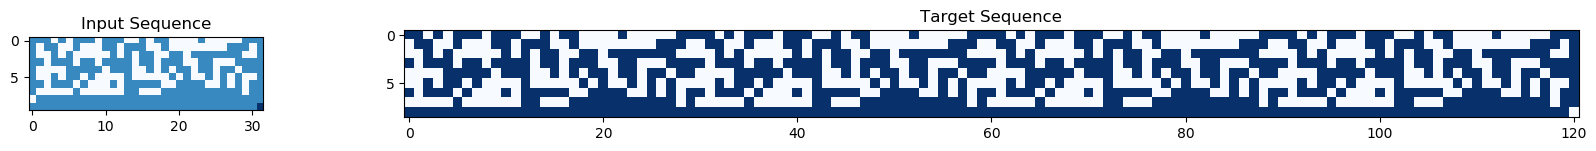

In [422]:
test = repeat_copy_dataloader(1,1,8,30,30,1,10,device)
x,y = next(test)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,20),gridspec_kw={'width_ratios': [1, 5]})
ax1.imshow(x.squeeze().t())
ax1.set_title("Input Sequence")
ax2.imshow(y.squeeze().t())
ax2.set_title("Target Sequence")
plt.show()

In [423]:
import numpy as np
def print_head(h):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,20))
    fig
    h = np.array(h)
    r = h[:,0,:,:]
    w = h[:,1,:,:]
   # ax1.figure(figsize=(10,20))
    ax1.imshow(r.T.squeeze())
    ax1.set_title("Read Head locations")
#     plt.show()
#     plt.figure(figsize=(10,20))
    ax2.imshow(w.T.squeeze())
    ax2.set_title("Write Head locations")
    plt.show()

In [424]:
# model = ntm
model = ntm_loaded
model.reset(batch_size=1)
with torch.no_grad():
    h1 =[]
    for i in range(x.size(0)):
            input = x[i]
            _,head = model(input)
            h1.append(head)
    outputs = torch.zeros(y.size())
    
    zero_input = torch.zeros([1,input_size])
    #     print("Finding Outputs")
    h2 =[]
    for i in range(y.size(0)):
        outputs[i],head = model(zero_input)
        h2.append(head)
    head_weights = np.concatenate((np.array(h1),np.array(h2)),axis=0)




## Output from network 

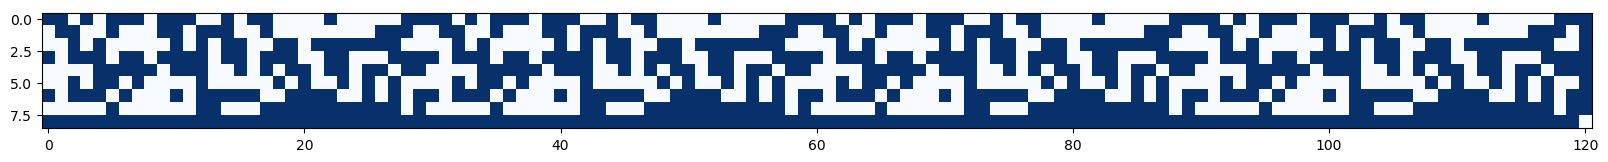

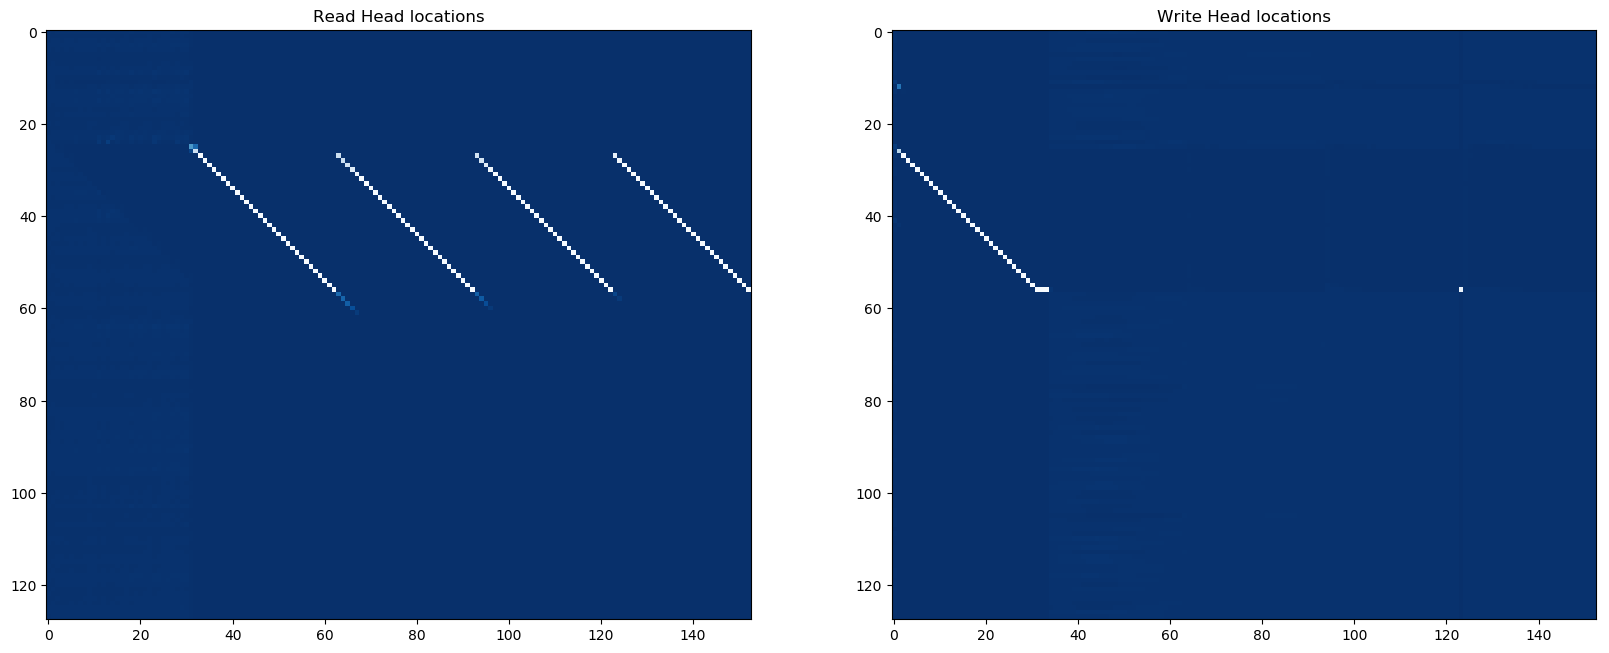

In [425]:
plt.figure(figsize=(20,20))
plt.imshow(outputs.squeeze().t())
print_head(head_weights)

## Error between target and output

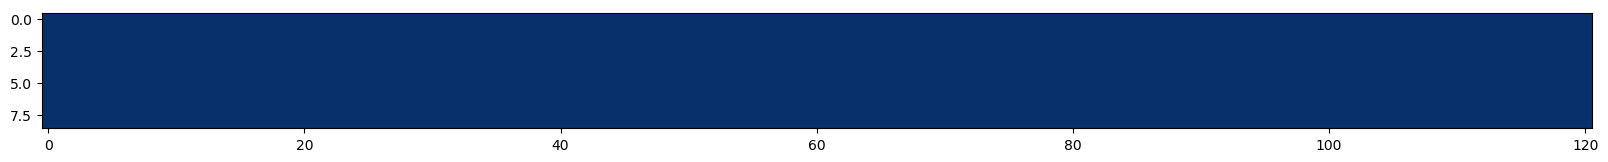

In [426]:
plt.figure(figsize=(20,20))
plt.imshow((y-outputs).round().squeeze().t())
plt.show()